<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%A1%D0%B0%D0%BC%D0%BE%D0%BF%D0%B8%D1%81%D0%BD%D1%8B%D0%B9_callback_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание Pro**

*В одной из баз - резюме или квартир - сделайте callback, который будет выводить на каждой эпохе:*

1. Текущую mae
2. График mae по всем эпохам на обучающей и проверочная выборках
3. Текущий scatter
4. Текущую гистограмму ошибок
5. Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
6. Изменяется ли шаг обучения, если начинается “пила” или mae выходит на плато
7. Сохраняет в .h5 сеть с лучшей точностью
*желательно использовать clear_output и verbose=0

**callback должен быть самописный, нельзя использовать готовые

In [ ]:
#импорт библиотек
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

import time
from IPython.display import clear_output
import keras.backend

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#загружаем данные в датафрейм
df = pd.read_csv('/content/drive/My Drive/data/moscow.csv', sep=";")
#удалим четные строки с комментариями
df = df.iloc[::2,:]
#извлечем данные в массив numpy
data = df.values
print(data)

[['1' 'Шелепиха м.' '12п' ... 1.0 'Привлекательные'
  'Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!']
 ['1' 'Пятницкое шоссе м.' '30т' ... 2.0 'Привлекат

In [ ]:
#посмотрим данные
df.head(10)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
10,1,Шелепиха м.,15п,9/36 К,NaN,NaN,44/14.7/19.2,12700000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,"1-комн. квартира в ЖК ""Сердце столицы"" на 9 эт..."
12,1,Улица Дмитриевского м.,2п,7/16 П,Л,Р,43/20/8,6500000.0,NaN,NaN,25.07.2019,14.0,Привлекательные,Предлагаю купить Однокомнатную квартиру с удоб...
14,1,Бульвар Рокоссовского м.,2п,2/5 К,Б,С,31/17/6,6000000.0,NaN,NaN,25.07.2019,15.0,Привлекательные,"Теплая, светлая квартира с высоким потолком в ..."
16,1,Марьина Роща м.,10п,7/14 П,2Б,NaN,38.9/20.9/8.5,8900000.0,NaN,NaN,25.07.2019,16.0,Привлекательные,"Продается 1-комн. квартира, площадью 38.9 м2 в..."
18,1,Марьино м.,20п,10/24 М-К,NaN,-,30.9/17.9/10,5999984.0,NaN,NaN,25.07.2019,16.0,Привлекательные,Предлагается уютная квартира в ЖК комфорт клас...


In [ ]:
#посмотрим названия колонок
print(df.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


In [ ]:
#функции для парсинга

def getRoomsCount(d, maxRoomCount):
    """
    функция вычисляет количество комнат в квартире
    на вход подается строка с описанием квартиры и
    maxRoomCount - максимальное число комнат в квартире
    """
    #получаем строку с числом комнат из датафрейма
    roomsCountStr = d[0]
    #создадим переменную для неопознанного количества комнат в квартире
    roomsCount = 0
    try:
        #пробуем превратить строку в число
        roomsCount = int(roomsCountStr)
        if (roomsCount > maxRoomCount):
            #если число комнат больше максимального, то присваиваем максимальное
            roomsCount = maxRoomCount
    except:
        #если не получается превратить строку в число
        #проверяем строку на nan (сравнение с самим собой)
        if (roomsCountStr == roomsCountStr):
            #если есть строка = "Ст", значит это Студия
            if ("Ст" in roomsCountStr):
                roomsCount = maxRoomCount + 1
    #возвращаем значение
    return roomsCount


def getRoomsCountCategory(d, maxRoomCount):
    "функция превращает число комнат в категорию"
    #получаем число комнат
    roomsCount = getRoomsCount(d, maxRoomCount)
    #превращаем в категорию
    roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2)
    #возвращаем значение
    return roomsCount


def getMetro(d, allMetroNames):
    """
    функция превращает станцию метро в индекс
    на вход подается строка с описанием квартиры и
    #allMetroNames - все уникальные названия метро в базе
    """
    #получаем строку метро
    metroStr = d[1]
    #создаем переменную для неопознанной станции метро
    metro = 0

    #если название метро есть в базе
    if (metroStr in allMetroNames):
        #присваиваем индекс
        metro = allMetroNames.index(metroStr)+1
    #возвращаем значение индекса
    return metro


def getMetroType(d):
    "функция превращает станцию метро в категорию"
    #получаем строку метро
    metroTypeStr = d[1]
    #назначаем число классов метро
    metroTypeClasses = 5
    #назначаем станцию изначально последним классом
    metroType = metroTypeClasses - 1

    #распределение станций метро на классы
    #Метро внутри кольца
    metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская",
                              "Красные Ворота", "Чистые пруды", "Лубянка",
                              "Охотный Ряд", "Библиотека имени Ленина",
                              "Кропоткинская", "Сухаревская", "Тургеневская",
                              "Китай-город", "Третьяковская", "Трубная",
                              "Сретенский бульвар", "Цветной бульвар",
                              "Чеховская", "Боровицкая", "Полянка",
                              "Маяковская", "Тверская", "Театральная",
                              "Новокузнецкая", "Пушкинская", "Кузнецкий Мост",
                              "Александровский сад"]
    #Метро на кольце
    metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская",
                        "Добрынинская", "Павелецкая", "Таганская", "Курская",
                        "Комсомольская", "Проспект Мира", "Новослободская",
                        "Белорусская", "Краснопресненская"]
    #Метро 1-3 станции от кольца
    metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская",
                              "Площадь Ильича", "Авиамоторная",
                              "Шоссе Энтузиастов", "Римская",
                              "Крестьянская Застава", "Дубровка",
                              "Пролетарская", "Волгоградский проспект",
                              "Текстильщики", "Автозаводская", "Технопарк",
                              "Коломенская", "Тульская", "Нагатинская",
                              "Нагорная", "Шаболовская", "Ленинский проспект",
                              "Академическая", "Фрунзенская", "Спортивная",
                              "Воробьёвы горы", "Студенческая", "Кутузовская",
                              "Фили", "Парк Победы", "Выставочная",
                              "Международная", "Улица 1905 года", "Беговая",
                              "Полежаевская", "Динамо", "Аэропорт", "Сокол",
                              "Деловой центр", "Шелепиха", "Хорошёвская",
                              "ЦСКА", "Петровский парк", "Савёловская",
                              "Дмитровская", "Тимирязевская", "Достоевская",
                              "Марьина Роща", "Бутырская", "Фонвизинская",
                              "Рижская", "Алексеевская", "ВДНХ",
                              "Красносельская", "Сокольники",
                              "Преображенская площадь"]
    #Метро 4-8 станций от кольа
    metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская",
                              "Щёлковская", "Новокосино", "Новогиреево",
                              "Перово", "Кузьминки", "Рязанский проспект",
                              "Выхино", "Лермонтовский проспект", "Жулебино",
                              "Улица Дмитриевского", "Кожуховская", "Печатники",
                              "Волжская", "Люблино", "Братиславская",
                              "Каширская", "Кантемировская", "Царицыно",
                              "Орехово", "Севастопольская", "Чертановская",
                              "Южная", "Пражская", "Варшавская", "Профсоюзная",
                              "Новые Черёмушки", "Калужская", "Беляево",
                              "Коньково", "Университет", "Багратионовская",
                              "Филёвский парк", "Пионерская", "Кунцевская",
                              "Молодёжная", "Октябрьское Поле", "Щукинская",
                              "Спартак", "Тушинская", "Сходненская",
                              "Войковская", "Водный стадион", "Речной вокзал",
                              "Беломорская", "Ховрино", "Петровско-Разумовская",
                              "Владыкино", "Отрадное", "Бибирево", "Алтуфьево",
                              "Окружная", "Верхние Лихоборы", "Селигерская",
                              "Ботанический сад", "Свиблово", "Бабушкинская",
                              "Медведково", "Черкизовская", 
                              "Бульвар Рокоссовского"]

    #проверяем в какую категорию попадает станция
    if (metroTypeStr in metroNamesInsideCircle):
        metroType = 0
    if (metroTypeStr in metroNamesCircle):
        metroType = 1
    if (metroTypeStr in metroNames13FromCircle):
        metroType = 2
    if (metroTypeStr in metroNames48FromCircle):
        metroType = 3
    
    #превращаем результаты в категорию
    metroType = utils.to_categorical(metroType, metroTypeClasses)
    #возвращаем результат
    return metroType


def getMetroDistance(d):
    """функция вычисляет расстояние до метро"""
    #получаем строку
    metroDistanceStr = d[2]
    #создаем переменную со значением расстояния до метро
    metroDistance = 0
    #создаем переменную с типом расстояния - пешком или на транспорте
    metroDistanceType = 0

    #проверяем, что строка не равна nan
    if (metroDistanceStr == metroDistanceStr):
        #проверяем, что значение не пустое
        if (len(metroDistanceStr) > 0):
            #определяем тип расстояния
            if (metroDistanceStr[-1] == "п"):
                #если тип расстояния указано пешком, переменную меняем на 1
                metroDistanceType = 1
            elif (metroDistanceStr[-1] == "т"):
                #если тип расстояния на транспорте, переменную меняем на 2
                metroDistanceType = 2

            #оставляем только числовое значение
            metroDistanceStr = metroDistanceStr[:-1]
            try:
                #разделяем дистанции на категории
                metroDistance = int(metroDistanceStr)
                if (metroDistance < 3):
                    metroDistance = 1
                elif (metroDistance < 6):
                    metroDistance = 2
                elif (metroDistance < 10):
                    metroDistance = 3
                elif (metroDistance < 15):
                    metroDistance = 4
                elif (metroDistance < 20):
                    metroDistance = 5
                else:
                    metroDistance = 6
            except:
                #если в строке не число, то категория 0
                metroDistance = 0
    
    #создаем переменную для числа классов дистанции
    metroDistanceClasses = 7

    """
    У нас 7 категорий дистанции по расстоянию
    И 3 типа дистанции - неопознанный, пешком и транспортом
    Мы создадим вектор длины 3*7 = 21
    Будем преобразовывать индекс расстояния 0-6 в 0-20
    Для типа "Пешком" - ничего не меняем
    """

    if (metroDistanceType == 2):
        #для типа "Транспортом" добавляем 7
        metroDistance += metroDistanceClasses
    if (metroDistanceType == 0):
        #Для неопознанного типа добавляем 14
        metroDistance += 2*metroDistanceClasses
    
    #превращаем в категории
    metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
    #возвращаем результат
    return metroDistance


#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
    """
    функция возвращает 4 данных:
     - этаж квартиры;
     - этажность дома;
     - индикатор последнего этажа;
     - тип дома
    """
    
    #получаем строку типа дома и этажей
    try:
        houseStr = d[3]
    except:
        houseStr = ""

    #переменная для типа дома
    houseType = 0
    #переменаая для этажа квартиры
    floor = 0
    #переменная для этажности дома
    floors = 0
    #индикатор последнего этажа
    isLastFloor = 0

    #проверяем строку на nan
    if (houseStr == houseStr):
        if (len(houseStr) > 1):
            try:
                #ищем разделитель /
                slashIndex = houseStr.index("/")
            except:
                print(houseStr)
            
            try:
                #ищем разделитель " "
                spaceIndex = houseStr.index(" ")
            except:
                print(houseStr)

            #строка этажа
            floorStr = houseStr[:slashIndex]
            #строка этажности дома
            floorsStr = houseStr[slashIndex+1:spaceIndex]
            #строка типа дома
            houseTypeStr = houseStr[spaceIndex+1:]

            #выбираем категорию этажа
            try:
                floor = int(floorStr)
                floorSave = floor
                if (floorSave < 5):
                    floor = 2
                if (floorSave < 10):
                    floor = 3
                if (floorSave < 20):
                    floor = 4
                if (floorSave >= 20):
                    floor = 5
                if (floorSave == 1):
                    #первый этаж выделяем в отдельную категорию
                    floor = 1
                if (int(floorStr) == int(floorsStr)):
                    #если этаж последний, включаем индикатор последнего этажа
                    isLastFloor = 1
            except:
                #если строка не преобразуется в число - отдельная категория этажа
                floor = 0
            
            #выбираем категорию этажности дома
            try:
                floors = int(floorsStr)
                floorsSave = floors
                if (floorsSave < 5):
                    floors = 1
                if (floorsSave < 10):
                    floors = 2
                if (floorsSave < 20):
                    floors = 3
                if (floorsSave >= 20):
                    floors = 4
            except:
                floors = 0
            
            #определяем категорию типа дома
            if (len(houseTypeStr) > 0):
                if ("М" in houseTypeStr):
                    houseType = 1
                if ("К" in houseTypeStr):
                    houseType = 2
                if ("П" in houseTypeStr):
                    houseType = 3
                if ("Б" in houseTypeStr):
                    houseType = 4
                if ("?" in houseTypeStr):
                    houseType = 5
                if ("-" in houseTypeStr):
                    houseType = 6

        #превращаем все категории в one hot encoding
        floor = utils.to_categorical(floor, 6)
        floors = utils.to_categorical(floors, 5)
        houseType = utils.to_categorical(houseType, 7)

    #возвращаем результат
    return floor, floors, isLastFloor, houseType


def getBalcony(d):
    "функция вычисляет тип балкона"
    balconyStr = d[4]
    #выписываем все варианты балконов в базе
    balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк',
                       'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
    #проверяем на nan
    if (balconyStr == balconyStr):
        #находим индекс строки балкона во всех строках
        balcony = balconyVariants.index(balconyStr)+1
    else:
        #индекс 0 выделяем на строку nan
        balcony = 0

    #превращаем в one hot encoding
    balcony = utils.to_categorical(balcony, 16)
    return balcony


def getWC(d):
    "функция определяет тип санузла"
    wcStr = d[5]
    #выписываем все варианты санузлов в базе
    wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4',
                  '3', '3Р']
    #проверяем на nan
    if (wcStr == wcStr):
        #находим индекс строки санузла во всех строках
        wc = wcVariants.index(wcStr)+1
    else:
        #индекс 0 выделяем на строку nan
        wc = 0
    
    #превращаем в one hot encoding
    wc = utils.to_categorical(wc, 14)
    return wc


def getArea(d):
    "функция возвращает полную площадь квартиры"
    areaStr = d[6]
    if ("/" in areaStr):
        #находим разделитель /
        slashIndex = areaStr.index("/")
        try:
            #берём число до разделителя и превращаем в число
            area = float(areaStr[:slashIndex])
        except:
            area = 0
    else:
        area = 0
    return area


def getCost(d):
    "функция возвращает стоимость квартиры"
    costStr = d[7]
    try:
        cost = float(costStr)
    except:
        cost = 0
    return cost


def getComment(d):
    "функция возвращат комментарии"
    commentStr = d[-1]
    return commentStr


def getAllParameters(d, allMetroNames):
    "функция объединяет все числовые параметры вместе"
    #загружаем все данные по отдельности
    roomsCountType = getRoomsCountCategory(d, 30)
    metro = getMetro(d, allMetroNames)
    metroType = getMetroType(d)
    metroDistance = getMetroDistance(d)
    floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
    balcony = getBalcony(d)
    wc = getWC(d)
    area = getArea(d)

    #объединяем в один лист
    out = list(roomsCountType)
    out.append(metro)
    out.extend(metroType)
    out.extend(metroDistance)
    out.extend(floor)
    out.extend(floors)
    out.append(isLastFloor)
    out.extend(houseType)
    out.extend(balcony)
    out.extend(wc)
    out.append(area)

    return out


def getXTrain(data):
    "функция генерирует обучающую выборку"
    #получаем строку во всеми вариантами метро
    allMertroNames = list(df["Метро / ЖД станции"].unique())

    #превращаем все строки в data1 в векторы параметров и записываем в xTrain
    xTrain = [getAllParameters(d, allMertroNames) for d in data]
    xTrain = np.array(xTrain)
    return xTrain


def getYTrain(data):
    "функция генерирует обучающую выборку"
    #загружаем лист всех цен квартир по всем строкам data1
    costList = [getCost(d) for d in data]
    yTrain = np.array(costList)
    return yTrain

In [ ]:
#в датафрейме оставляем только однокомнатные квартиры
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data]
data1 = data[oneRoomMask]
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
#загрузим числовые данные
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)
print(yTrain.shape)

(62504, 109)
(62504,)


In [ ]:
#обработаем примечания
texts = data1[:, -1]
texts[0]

'Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!'

In [ ]:
#удалим сложные слова с числами из примечаний
texts = list(map(lambda x: x if type(x) == str else '', texts))

In [ ]:
#определим максимальное количество слов для обучения
maxWordsCount = 2000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#соберем словарь частотности
tokenizer.fit_on_texts(texts)
#преобразуем тексты в последовательность индексов согласно частотному словарю
xTrainCWordIndexes = tokenizer.texts_to_sequences(texts)
#преобразуем выборки из последовательности индексов в матрицы 0 и 1
xTrainC01 = tokenizer.sequences_to_matrix(xTrainCWordIndexes)

In [ ]:
#выводим размеры обучающей выборки
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


In [ ]:
#нормируем площадь квартиры в выборке
xScaler = StandardScaler()
#создаем нормировщик и обучаем его на площадях квартир
xScaler.fit(xTrain[:,-1].reshape(-1, 1))
xTrainScaled = xTrain.copy()
#нормируем данные
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten()

#выводим размер и примеры для сравнения ненормированных и нормированных данных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#нормируем цену квартиры
yScaler = StandardScaler()
yScaler.fit(yTrain.reshape(-1, 1))
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


In [ ]:
#сформируем проверочную выборку в 20% от всей выборки
splitVal = 0.2
#создаем маску для создания проверочной выборки
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal

# Функция для коллбэков

In [ ]:
#создадим переменные для значений средней абсолютной ошибки на выборках
mae = []
val_mae = []
epoch_time_start = 0
epoch_time_sum = 0
#создаем переменную для сравнения с лучшей точностью
best_mae = 100000

def on_epoch_begin(epoch, logs):
    global epoch_time_start
    epoch_time_start = time.time()
    return epoch_time_start


def on_epoch_end(epoch, logs):
    
    #clear_output()


    #зафиксируем время обучения на эпоху
    current_datetime = time.time()

    #получаем предсказанное значение на проверочной выборке
    pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])
    #делаем обратное нормирование предсказанной цены
    predUnscaled = yScaler.inverse_transform(pred).flatten()/1000000
    #делаем обратное нормирование базовой цены на квартиру
    yUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()/1000000
    delta = abs(predUnscaled - yUnscaled)
    
    #выводим текущее значение средней абсолютной ошибки
    print('==================== Эпоха', epoch + 1, '====================')
    print()
    print("Текущее значение средней абсолютной ошибки:", round(sum(delta) / len(delta),3))
    print()
    
    #сохраняем значения средней абсолютной ошибки на выборках
    mae.append(logs['mae'])
    val_mae.append(logs['val_mae'])
    #выводим график значения средней абсолютной ошибки
    plt.plot(mae, label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(val_mae, label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.title('Средняя абсолютная ошибка по всем эпохам')
    plt.legend()
    plt.show()

    #нарисуем scatter ошибок
    print()
    plt.scatter(yUnscaled, predUnscaled)
    plt.xlabel('Правильное значение, млн руб.')
    plt.ylabel('Предсказанное значение, млн руб.')
    plt.axis('equal')
    plt.title('Ошибка в прогнозе')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 10000000], [-100, 10000000])
    plt.show()

    #нарисуем гистограмму ошибок
    print()
    plt.hist(delta, bins=len(delta))
    plt.xlabel('Модуль значения ошибки, млн руб.')
    plt.ylabel('Количество')
    plt.title('Текущая гистограмма ошибок')
    plt.xlim([0, 10])
    plt.show()

    #вывод времени обучения
    print()
    #посчитаем время обучения на эпоху
    epoch_time = current_datetime - epoch_time_start
    print('Время обучения на текущей эпохе:', round(epoch_time, 2), 'сек.')
    #общее время обучения
    global epoch_time_sum
    epoch_time_sum += epoch_time
    print('Общее время обучения:', round(epoch_time_sum, 2), 'сек.')
    #сколько времени остается до конца обучения
    epoch_time_avg = epoch_time_sum / (epoch + 1)
    time_remaining = round(((epochs - (epoch + 1)) * epoch_time_avg), 0)
    hour_time_remaining = int(time_remaining / 3600)
    min_time_remaining = int((time_remaining - hour_time_remaining * 3600) / 60)
    sec_time_remaining = int(time_remaining - hour_time_remaining * 3600 - min_time_remaining * 60)
    print('Количество времени до конца обучения: ', hour_time_remaining, 'ч.', min_time_remaining, 'мин.', sec_time_remaining, 'сек.')

    #изменение шага обучения, если начинается "пила" или mae выходит на плато
    #будем сравнивать значения mae с 4-ой эпохи
    if epoch > 3:
        #сравниваем значения ошибки на 3-х последних эпохах
        past_mae = val_mae[(epoch-3):]
        #сравним среднее значение с минимальным значением, увеличенным на 0.01
        if np.mean(past_mae) < (np.min(past_mae) + 0.01):
            #увеличиваем шаг
            model.optimizer.lr.assign(keras.backend.eval(model.optimizer.lr) * 2)
            print()
            print('Вышли на плато, шаг обучения был изменен на:', keras.backend.eval(model.optimizer.lr))
        #сравниваем предыдущие значения
        if (val_mae[epoch - 3] > val_mae[epoch - 2] < val_mae[epoch - 1] > val_mae[epoch] or val_mae[epoch - 3] < val_mae[epoch - 2] > val_mae[epoch - 1] < val_mae[epoch]) and np.mean(past_mae) > (np.min(past_mae) + 0.01):
            #уменьшаем шаг
            model.optimizer.lr.assign(keras.backend.eval(model.optimizer.lr) * 0.5)
            print()
            print('Началась "пила", шаг обучения был изменен на:', keras.backend.eval(model.optimizer.lr))
    
    #сохранение сети с лучшей точностью
    global best_mae
    if logs['val_mae'] < best_mae:
        model.save_weights("best_mae.h5")
        best_mae = logs['val_mae']
        print()
        print('Сохранено лучшее значение')

    
#коллбэки
callbacks = LambdaCallback(on_epoch_end=on_epoch_end,
                          on_epoch_begin=on_epoch_begin)

==================== Эпоха 1 ====================

Текущее значение средней абсолютной ошибки: 2.163



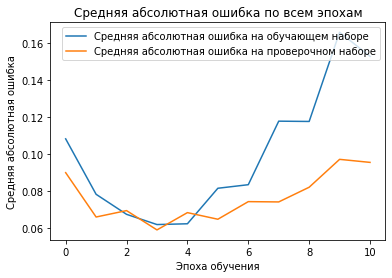

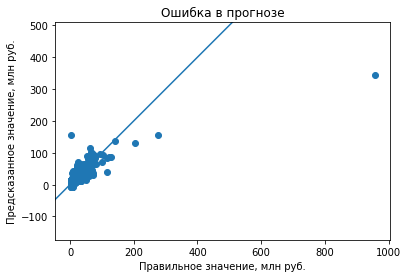

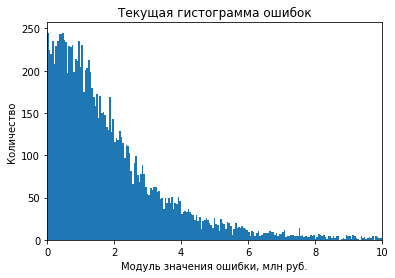


Время обучения на текущей эпохе: 4.76 сек.
Общее время обучения: 48.34 сек.
Количество времени до конца обучения:  0 ч. 7 мин. 15 сек.
==================== Эпоха 2 ====================

Текущее значение средней абсолютной ошибки: 2.236



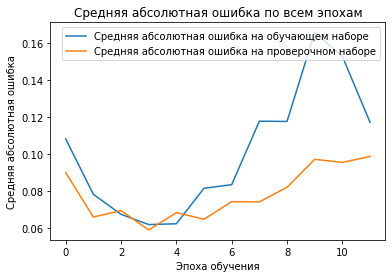

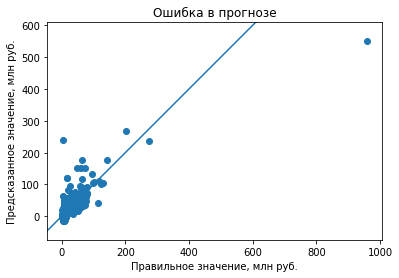

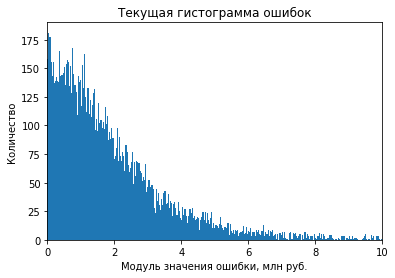


Время обучения на текущей эпохе: 4.46 сек.
Общее время обучения: 52.8 сек.
Количество времени до конца обучения:  0 ч. 3 мин. 31 сек.
==================== Эпоха 3 ====================

Текущее значение средней абсолютной ошибки: 1.534



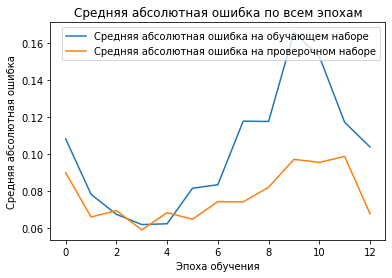

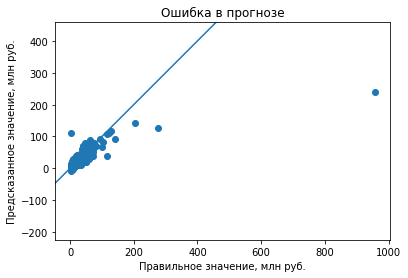

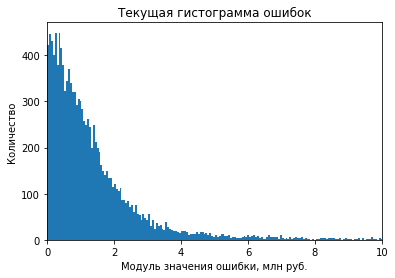


Время обучения на текущей эпохе: 4.48 сек.
Общее время обучения: 57.29 сек.
Количество времени до конца обучения:  0 ч. 2 мин. 14 сек.
==================== Эпоха 4 ====================

Текущее значение средней абсолютной ошибки: 1.516



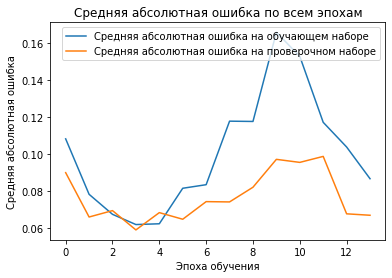

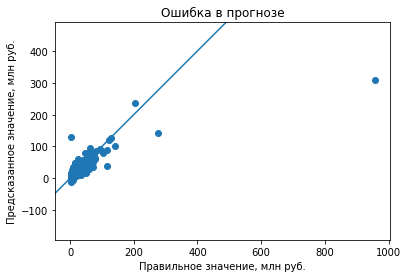

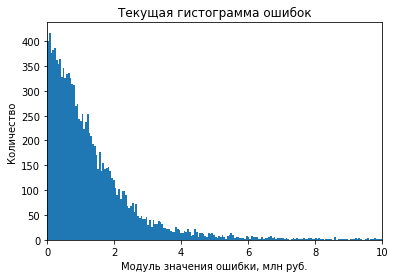


Время обучения на текущей эпохе: 4.13 сек.
Общее время обучения: 61.42 сек.
Количество времени до конца обучения:  0 ч. 1 мин. 32 сек.
==================== Эпоха 5 ====================

Текущее значение средней абсолютной ошибки: 1.458



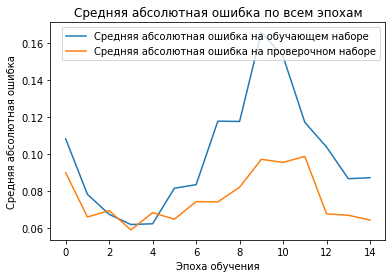

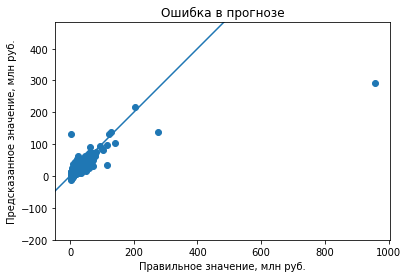

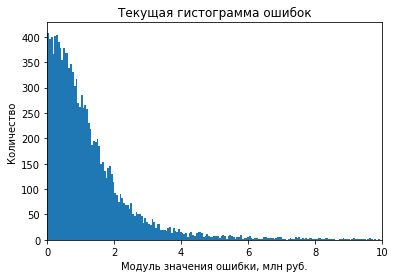


Время обучения на текущей эпохе: 4.18 сек.
Общее время обучения: 65.6 сек.
Количество времени до конца обучения:  0 ч. 1 мин. 6 сек.

Началась "пила", шаг обучения был изменен на: 0.0005
==================== Эпоха 6 ====================

Текущее значение средней абсолютной ошибки: 2.311



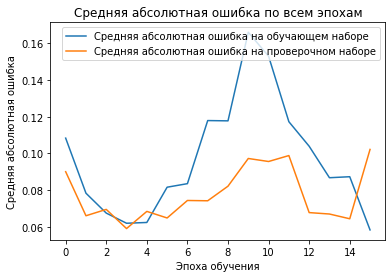

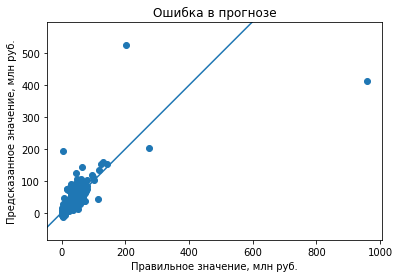

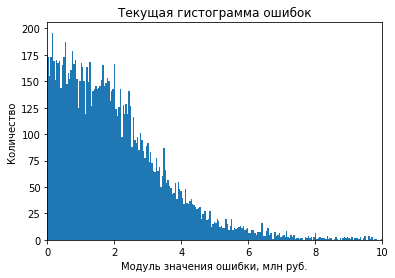


Время обучения на текущей эпохе: 4.53 сек.
Общее время обучения: 70.12 сек.
Количество времени до конца обучения:  0 ч. 0 мин. 47 сек.

Началась "пила", шаг обучения был изменен на: 0.00025
==================== Эпоха 7 ====================

Текущее значение средней абсолютной ошибки: 1.217



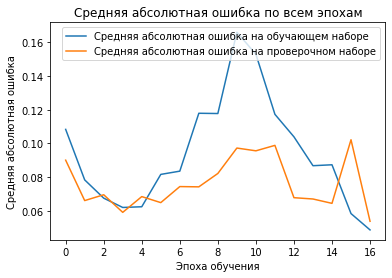

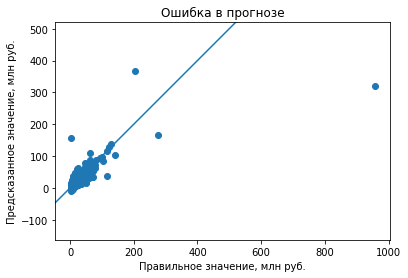

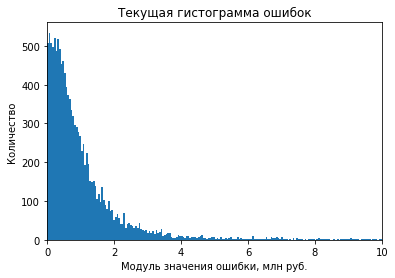


Время обучения на текущей эпохе: 4.25 сек.
Общее время обучения: 74.37 сек.
Количество времени до конца обучения:  0 ч. 0 мин. 32 сек.

Началась "пила", шаг обучения был изменен на: 0.000125

Сохранено лучшее значение
==================== Эпоха 8 ====================

Текущее значение средней абсолютной ошибки: 1.224



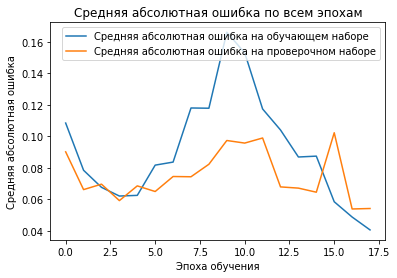

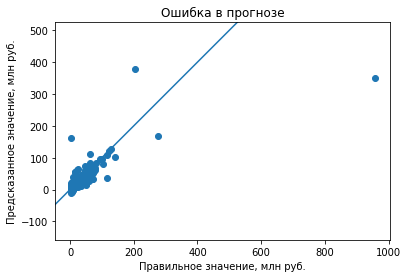

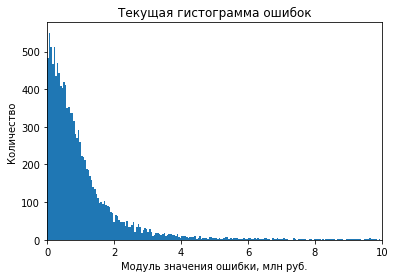


Время обучения на текущей эпохе: 4.48 сек.
Общее время обучения: 78.85 сек.
Количество времени до конца обучения:  0 ч. 0 мин. 20 сек.

Началась "пила", шаг обучения был изменен на: 6.25e-05
==================== Эпоха 9 ====================

Текущее значение средней абсолютной ошибки: 1.17



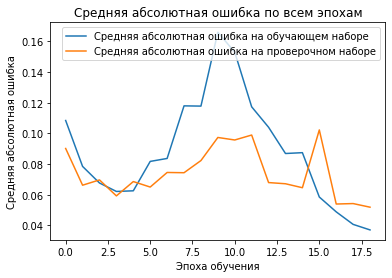

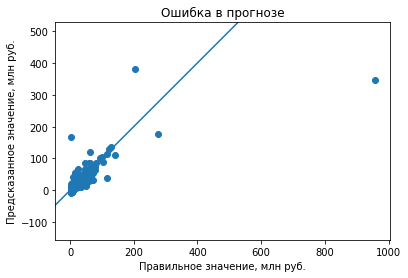

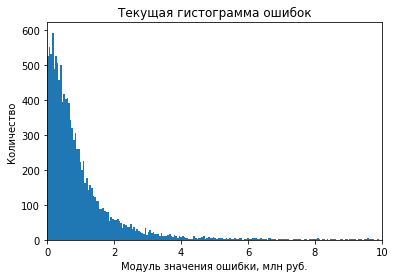


Время обучения на текущей эпохе: 4.08 сек.
Общее время обучения: 82.94 сек.
Количество времени до конца обучения:  0 ч. 0 мин. 9 сек.

Началась "пила", шаг обучения был изменен на: 3.125e-05

Сохранено лучшее значение
==================== Эпоха 10 ====================

Текущее значение средней абсолютной ошибки: 1.206



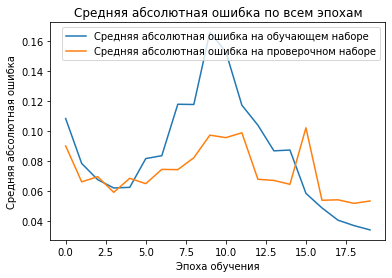

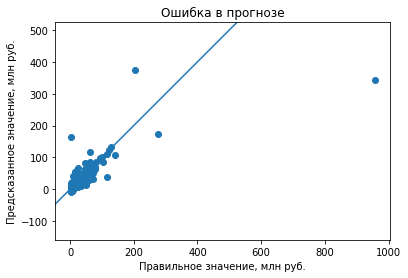

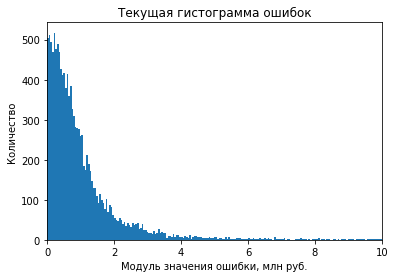


Время обучения на текущей эпохе: 4.14 сек.
Общее время обучения: 87.08 сек.
Количество времени до конца обучения:  0 ч. 0 мин. 0 сек.


In [ ]:
#устанавливаем значение количества эпох
epochs = 10

#создаем модель

#простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask], epochs=epochs,
                    validation_data=([xTrainScaled[valMask],
                                      xTrainC01[valMask]],
                                      yTrainScaled[valMask]),
                    verbose=0, callbacks=[callbacks])